In [6]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from sklearn.decomposition import PCA

# Helper Functions
def setup_bayesian_gplvm(Y_noisy, Q, kernel_params, num_inducing=15):
    """Set up and return a Bayesian GPLVM model."""
    pca = PCA(n_components=Q)
    X_init = pca.fit_transform(Y_noisy)
    kernel = GPy.kern.RBF(Q, **kernel_params)
    model = GPy.models.BayesianGPLVM(Y_noisy, input_dim=Q, X=X_init, kernel=kernel, num_inducing=num_inducing)
    return model

def plot_latent_space(X_true, X_mean, X_var, title):
    """Plot true and inferred latent spaces with uncertainty."""
    plt.figure(figsize=(6, 6))
    plt.scatter(X_true[:, 0], X_true[:, 1], c='blue', alpha=0.7, label="True Latent Space")
    plt.scatter(X_mean[:, 0], X_mean[:, 1], c='red', alpha=0.7, label="Inferred Latent Mean")
    for i in range(len(X_mean)):
        std_x1, std_x2 = np.sqrt(X_var[i])
        ellipse = plt.Circle((X_mean[i, 0], X_mean[i, 1]), radius=2*std_x1, fill=False, color='gray', alpha=0.3)
        plt.gca().add_patch(ellipse)
    plt.title(title)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()
    plt.grid()
    plt.show()

def plot_reconstructed_data(Y_noisy, Y_recon, title):
    """Plot observed and reconstructed data."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].scatter(Y_noisy[:, 0], Y_noisy[:, 1], c='blue', alpha=0.7, label="Observed Data")
    ax[0].set_title("Observed Data")
    ax[0].set_xlabel("$y_1$")
    ax[0].set_ylabel("$y_2$")
    ax[1].scatter(Y_recon[:, 0], Y_recon[:, 1], c='red', alpha=0.7, label="Reconstructed Data")
    ax[1].set_title(title)
    ax[1].set_xlabel("$\hat{y}_1$")
    ax[1].set_ylabel("$\hat{y}_2$")
    plt.tight_layout()
    plt.show()

In [7]:
def experiment1():
    """Experiment 1: Synthetic Spiral Latent Space."""
    # Parameters
    N, Q, D = 100, 2, 2
    noise_std = 0.05
    np.random.seed(42)

    # Generate spiral data
    theta = np.linspace(0, 2 * np.pi, N)
    r = np.linspace(0.1, 1.0, N)
    X_true = np.vstack((r * np.cos(theta), r * np.sin(theta))).T

    def latent_to_observed(x):
        y1 = np.sin(x[0]) + np.cos(x[1])
        y2 = x[0]**2 + x[1]
        return np.array([y1, y2])

    Y = np.array([latent_to_observed(x) for x in X_true])
    Y_noisy = Y + np.random.randn(N, D) * noise_std

    # Bayesian GPLVM
    kernel_params = {"variance": 1.0, "lengthscale": 0.5, "ARD": False}
    model = setup_bayesian_gplvm(Y_noisy, Q, kernel_params)
    model.optimize(messages=True, max_iters=500)

    # Results
    X_mean = model.X.mean.values
    X_var = model.X.variance.values
    Y_recon = model.predict(X_mean)[0]

    # Plot Results
    plot_latent_space(X_true, X_mean, X_var, "Experiment 1: Spiral Latent Space")
    plot_reconstructed_data(Y_noisy, Y_recon, "Reconstructed Data (Experiment 1)")

In [8]:
def experiment2():
    """Experiment 2: Synthetic Data with Uncertain Inputs."""
    # Parameters
    N, Q, D = 100, 2, 2
    noise_std = 0.1
    np.random.seed(42)

    # Latent variables and noisy observed data
    X_true = np.random.randn(N, Q)

    def latent_to_observed(x):
        y1 = np.sin(x[0]) + 0.5 * np.cos(2 * x[1])
        y2 = np.exp(-0.5 * (x[0]**2 + x[1]**2))
        return np.array([y1, y2])

    Y = np.array([latent_to_observed(x) for x in X_true])
    Y_noisy = Y + np.random.randn(N, D) * noise_std

    # Bayesian GPLVM
    kernel_params = {"variance": 1.0, "lengthscale": 1.0, "ARD": False}
    model = setup_bayesian_gplvm(Y_noisy, Q, kernel_params)
    model.optimize(messages=True, max_iters=500)

    # Results
    X_mean = model.X.mean.values
    X_var = model.X.variance.values
    Y_recon = model.predict(X_mean)[0]

    # Plot Results
    plot_latent_space(X_true, X_mean, X_var, "Experiment 2: Uncertain Inputs")
    plot_reconstructed_data(Y_noisy, Y_recon, "Reconstructed Data (Experiment 2)")

In [10]:
def experiment3():
    """Experiment 3: Temporal Data in Latent Space."""
    # Parameters
    N, Q, D = 150, 1, 2
    noise_std = 0.05
    np.random.seed(42)

    # Temporal data generation
    t = np.linspace(0, 6 * np.pi, N)
    X_true = (np.sin(t) * np.exp(-0.05 * t)).reshape(-1, Q)

    def latent_to_observed_time(x, time_idx):
        y1 = np.sin(2 * x[0]) + 0.3 * time_idx / N
        y2 = np.cos(x[0]) * (1 - time_idx / N)
        return np.array([y1, y2])

    Y = np.array([latent_to_observed_time(X_true[i], i) for i in range(N)])
    Y_noisy = Y + np.random.randn(N, D) * noise_std

    # Bayesian GPLVM
    kernel_params = {"variance": 1.0, "lengthscale": 1.0, "ARD": False}
    model = setup_bayesian_gplvm(Y_noisy, Q, kernel_params)
    model.optimize(messages=True, max_iters=500)

    # Results
    X_mean = model.X.mean.values
    X_var = model.X.variance.values
    Y_recon = model.predict(X_mean)[0]

    # Log-Likelihood and Reconstruction Error
    print(f"Log-likelihood after optimization: {model.log_likelihood()}")
    reconstruction_error = np.mean((Y_noisy - Y_recon)**2)
    print(f"Reconstruction Error: {reconstruction_error:.4f}")

    # Latent Trajectory Plot
    plt.figure(figsize=(10, 6))
    plt.plot(t, X_true, label="True Latent Trajectory")
    plt.plot(t, X_mean, 'r', label="Inferred Latent Mean")
    plt.fill_between(t, X_mean.flatten() - 2 * np.sqrt(X_var.flatten()),
                     X_mean.flatten() + 2 * np.sqrt(X_var.flatten()), color='r', alpha=0.2, label="Uncertainty")
    plt.title("Experiment 3: Temporal Data")
    plt.xlabel("Time")
    plt.ylabel("Latent Variable")
    plt.legend()
    plt.grid()
    plt.show()

    # Observed vs Reconstructed Data Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_noisy[:, 0], Y_noisy[:, 1], label="Noisy Observations", alpha=0.6)
    plt.scatter(Y_recon[:, 0], Y_recon[:, 1], label="Reconstructed Observations", alpha=0.6)
    plt.title("Observed vs. Reconstructed Data")
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.legend()
    plt.grid()
    plt.show()

Choose an experiment to run:
1. Experiment 1: Spiral Latent Space
2. Experiment 2: Uncertain Inputs
3. Experiment 3: Temporal Data
4. Run All Experiments
Running all experiments...


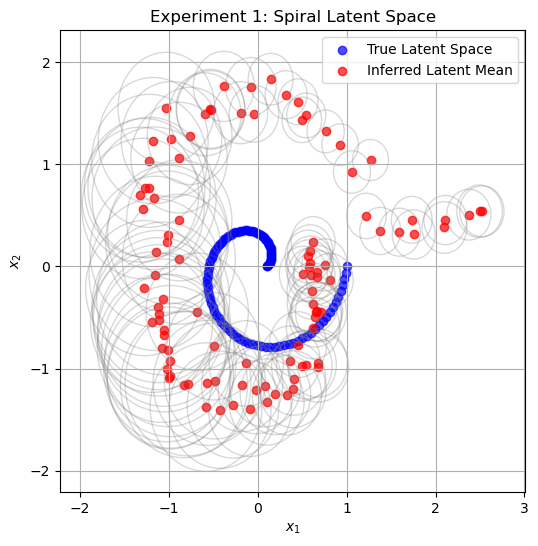

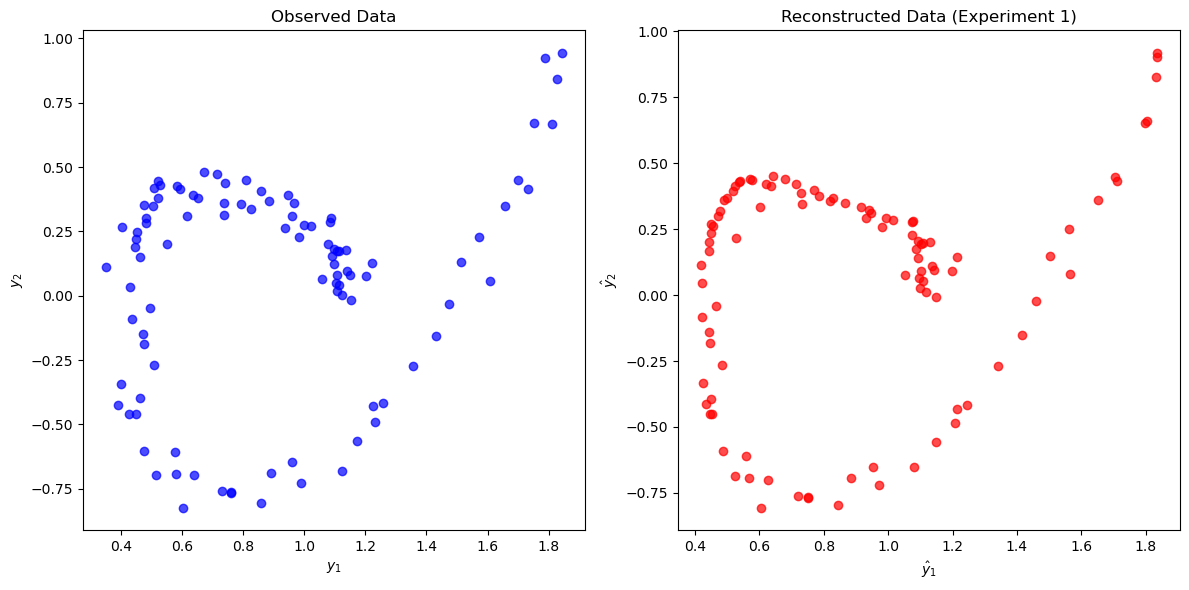

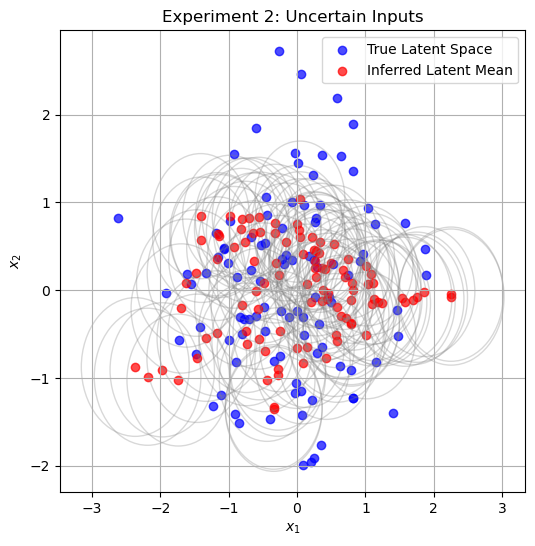

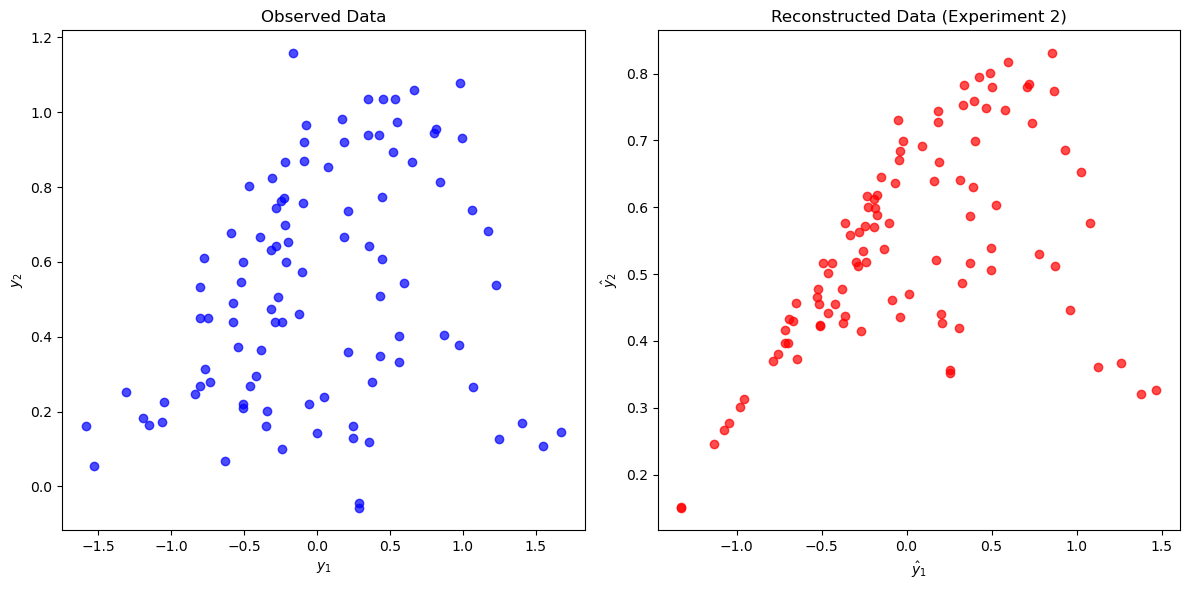

Log-likelihood after optimization: [[-155.71583912]]
Reconstruction Error: 0.0251


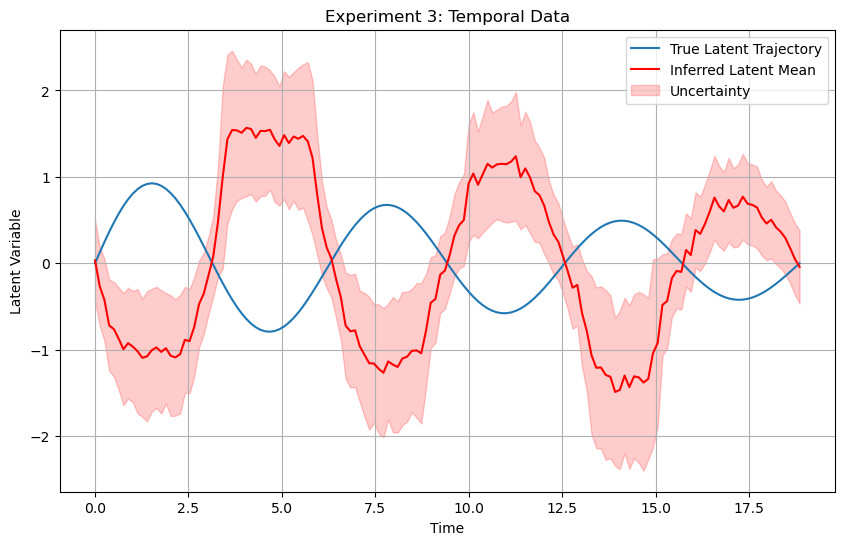

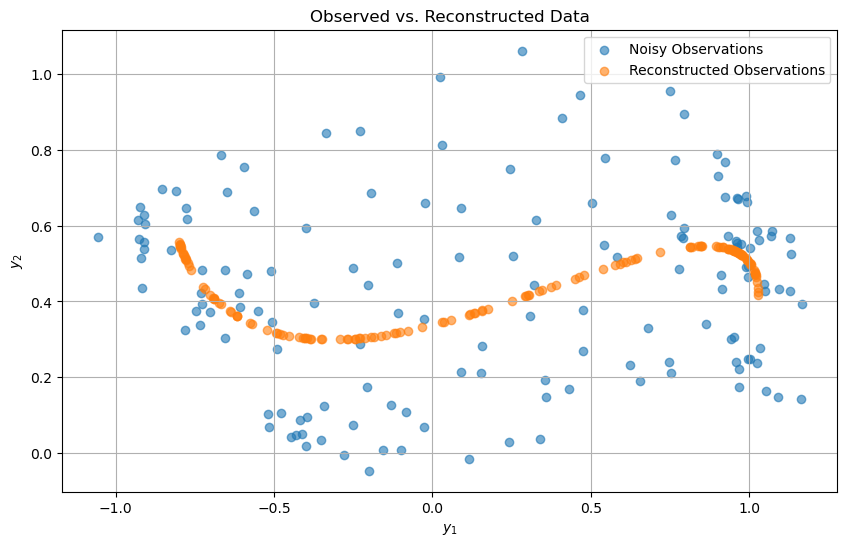

In [11]:
def main():
    print("Choose an experiment to run:")
    print("1. Experiment 1: Spiral Latent Space")
    print("2. Experiment 2: Uncertain Inputs")
    print("3. Experiment 3: Temporal Data")
    print("4. Run All Experiments")

    choice = input("Enter your choice (1/2/3/4): ")

    if choice == "1":
        experiment1()
    elif choice == "2":
        experiment2()
    elif choice == "3":
        experiment3()
    elif choice == "4":
        print("Running all experiments...")
        experiment1()
        experiment2()
        experiment3()
    else:
        print("Invalid choice. Exiting.")

# Run main
if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

def setup_bayesian_gplvm(Y_train, Q, num_inducing=20):
    """Set up and return a Bayesian GPLVM model with ARD kernel."""
    # PCA initialization
    pca = PCA(n_components=Q)
    X_init = pca.fit_transform(Y_train)
    # Use ARD in RBF kernel
    kernel = GPy.kern.RBF(Q, ARD=True)  # ARD = True for separate lengthscales
    model = GPy.models.BayesianGPLVM(Y_train, input_dim=Q, X=X_init, kernel=kernel, num_inducing=num_inducing)
    return model

def evaluate_model(model, Y_test):
    """Compute the predictive mean squared error and predictive log likelihood on test data."""
    X_mean_test = model.X.mean.values
    Y_pred, Y_var = model.predict(X_mean_test)
    mse = mean_squared_error(Y_test, Y_pred)
    sigma2 = 1.0/model.beta.values
    log_lik = np.sum(-0.5*np.log(2*np.pi*sigma2) - 0.5*((Y_test - Y_pred)**2)/sigma2)
    return mse, log_lik

def plot_ARD_scales(kern):
    """Plot ARD lengthscales to show how model selects relevant latent dimensions."""
    if hasattr(kern, 'lengthscale') and len(kern.lengthscale.shape) > 0:
        plt.figure(figsize=(6,4))
        plt.bar(range(len(kern.lengthscale)), kern.lengthscale, color='orange', alpha=0.7)
        plt.title("Experiment 4: ARD Lengthscales")
        plt.xlabel("Latent Dimension")
        plt.ylabel("Lengthscale")
        plt.grid(True)
        plt.show()
    else:
        print("No ARD lengthscales found.")

def run_experiment_4():
    N = 200
    D = 5    # higher-dimensional observed space
    Q = 2    # latent dimensionality
    noise_std = 0.1
    np.random.seed(42)

    # Generate some synthetic latent variables
    X_true = np.random.randn(N, Q)
    W = np.random.randn(Q, D) * 0.5

    def latent_to_observed(x):
        # nonlinear mapping for each dimension of Y
        return np.array([np.sin(x[0]*W[0, d]) + np.cos(x[1]*W[1, d]) for d in range(D)])

    Y = np.array([latent_to_observed(x) for x in X_true])
    Y_noisy = Y + np.random.randn(N, D)*noise_std

    N_train = 150
    Y_train = Y_noisy[:N_train]
    Y_test = Y_noisy[N_train:]
    X_true_test = X_true[N_train:]

    model = setup_bayesian_gplvm(Y_train, Q=Q, num_inducing=20)

    model.optimize(messages=True, max_iters=700)

    # Evaluate model
    # mse_test, log_lik_test = evaluate_model(model, Y_test)
    # print("Test MSE:", mse_test)
    # print("Test Predictive Log Likelihood:", log_lik_test)

    # Plot ARD lengthscales
    plot_ARD_scales(model.kern)

    # Compare with PCA reconstruction as a baseline
    pca = PCA(n_components=Q)
    Z_pca = pca.fit_transform(Y_train)
    Y_pca_recon = pca.inverse_transform(Z_pca)
    mse_pca_train = mean_squared_error(Y_train, Y_pca_recon)
    print("PCA reconstruction error (training):", mse_pca_train)

    X_mean = model.X.mean.values
    plt.figure(figsize=(6,6))
    plt.scatter(X_true[:N_train,0], X_true[:N_train,1], c='blue', alpha=0.5, label='True Latent (Train)')
    plt.scatter(X_mean[:,0], X_mean[:,1], c='red', alpha=0.5, label='Inferred Latent')
    plt.title("Experiment 4: Inferred vs. True Latent Spaces (Train)")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Show uncertainty ellipses on latent space
    X_var = model.X.variance.values
    plt.figure(figsize=(6,6))
    plt.scatter(X_mean[:,0], X_mean[:,1], c='red', alpha=0.7, label='Inferred Latent Mean')
    for i in range(len(X_mean)):
        # just plot one radius as a circle for simplicity
        std_x1 = np.sqrt(X_var[i,0])
        ellipse = plt.Circle((X_mean[i,0], X_mean[i,1]),
                             radius=2*std_x1, fill=False,
                             color='gray', alpha=0.3)
        plt.gca().add_patch(ellipse)
    plt.title("Experiment 4: Inferred Latent Means with Uncertainty (Train)")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Reconstruct training data from model
    Y_recon_train, _ = model.predict(X_mean)
    mse_train = mean_squared_error(Y_train, Y_recon_train)
    print("GPLVM reconstruction error (training):", mse_train)
    print("GPLVM improvement over PCA:", mse_pca_train - mse_train)

    # Plot observed vs reconstructed for training
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].scatter(Y_train[:,0], Y_train[:,1], c='blue', alpha=0.7)
    ax[0].set_title("Experiment 4: Observed Training Data")
    ax[0].set_xlabel("$y_1$")
    ax[0].set_ylabel("$y_2$")
    ax[1].scatter(Y_recon_train[:,0], Y_recon_train[:,1], c='red', alpha=0.7)
    ax[1].set_title("Experiment 4: Reconstructed from GPLVM")
    ax[1].set_xlabel("$\hat{y}_1$")
    ax[1].set_ylabel("$\hat{y}_2$")
    plt.tight_layout()
    plt.show()


In [2]:
#fail to start from scratch

# Failing codes.

In [ ]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def pca_init(Y, Q):
    Ymean = Y.mean(axis=0, keepdims=True)
    Yc = Y - Ymean
    C = np.cov(Yc, rowvar=False)
    vals, vecs = eigh(C)
    idx = np.argsort(vals)[::-1]
    vecs = vecs[:, idx[:Q]]
    X_init = Yc @ vecs
    return X_init

def rbfard2_kernel(X, X2, variance, lengthscales):
    if X2 is None:
        X2 = X
    invls = 1.0/(lengthscales**2)
    diff = cdist(X * np.sqrt(invls), X2 * np.sqrt(invls), 'sqeuclidean')
    return variance * np.exp(-0.5*diff)

def psi0_compute(variance, N):
    return N * variance

def psi1_compute(Xmean, Z, variance, lengthscales, Xcovars=None):

    N = Xmean.shape[0]
    M = Z.shape[0]
    Q = Xmean.shape[1]
    ell = lengthscales
    Psi1 = np.zeros((N,M))
    for n in range(N):
        m_n = Xmean[n,:]
        if Xcovars is not None:
            S_n = Xcovars[n,:]
        else:
            S_n = np.zeros(Q)
        factor = 1.0
        exponent = 0.0
        for q in range(Q):
            denom = ell[q]**2 + S_n[q]
            factor *= (ell[q]/np.sqrt(denom))
        inv_scales = 1.0/(ell**2 + S_n)
        diff = (Z - m_n)**2
        exponent = -0.5*np.sum(diff*inv_scales[None,:], axis=1)
        Psi1[n,:] = variance * factor * np.exp(exponent)
    return Psi1

def psi2_compute(Xmean, Z, variance, lengthscales, Xcovars=None):
    Psi1val = psi1_compute(Xmean, Z, variance, lengthscales, Xcovars)
    Psi2_approx = (Psi1val.T @ Psi1val)/Xmean.shape[0]
    Psi2_approx += np.eye(Z.shape[0])*1e-7
    return Psi2_approx

class VarGPLVM:
    def __init__(self, Y, Q, M=20, seed=0, uncertain_inputs=False, temporal=False):
        np.random.seed(seed)
        self.Y = Y
        self.N, self.D = Y.shape
        self.Q = Q
        self.M = M
        self.variance = 1.0
        self.lengthscales = np.ones(self.Q)
        self.beta = 100.0
        self.learning_rate = 1e-4
        self.iters = 500
        self.uncertain_inputs = uncertain_inputs
        self.temporal = temporal

        self.X_mean = pca_init(Y, Q)
        idx = np.random.choice(self.N, self.M, replace=False)
        self.Z = self.X_mean[idx,:].copy()

        if self.uncertain_inputs:
            self.X_covars = 0.05*np.ones((self.N,self.Q))
        else:
            self.X_covars = None

        if self.temporal:
            self.time = np.arange(self.N)

    def compute_stats(self):
        K_uu = rbfard2_kernel(self.Z, None, self.variance, self.lengthscales)
        K_uu += np.eye(self.M)*1e-6
        Lm = cholesky(K_uu)
        invLm = solve(Lm, np.eye(self.M))

        Psi0 = psi0_compute(self.variance, self.N)
        Psi1_mat = psi1_compute(self.X_mean, self.Z, self.variance, self.lengthscales, self.X_covars)
        Psi2_mat = psi2_compute(self.X_mean, self.Z, self.variance, self.lengthscales, self.X_covars)
        C = invLm.dot(Psi2_mat).dot(invLm.T)
        At = (1/self.beta)*np.eye(self.M) + C
        Lat = cholesky(At)
        invLat = solve(Lat, np.eye(self.M))

        Ytilde = self.Y
        P = invLat.dot(invLm).dot(Psi1_mat.T).dot(Ytilde)
        return (invLm, Psi0, Psi1_mat, Psi2_mat, C, At, Lat, invLat, P)

    def temporal_prior(self):
        pen = 0.0
        for t in range(self.N-1):
            diff = self.X_mean[t+1,:]-self.X_mean[t,:]
            pen += np.sum(diff**2)
        return -0.5*pen # negative since we add this to ll

    def log_likelihood(self):
        invLm, Psi0, Psi1_mat, Psi2_mat, C, At, Lat, invLat, P = self.compute_stats()
        TrPP = np.sum(P*P)
        TrC = np.sum(np.diag(C))
        logDetAt = 2.0*np.sum(np.log(np.diag(Lat)))

        TrYY = np.sum(self.Y*self.Y)

        if self.X_covars is not None:
            KLx = 0.5 * np.sum(self.X_mean**2 + self.X_covars - np.log(self.X_covars)) - 0.5*self.N*self.Q
        else:
            KLx = 0.5*np.sum(self.X_mean**2)

        reg = 0.001*((self.variance-1)**2 + (self.beta-100)**2 + np.sum((self.lengthscales-1)**2))
        varX = np.var(self.X_mean, axis=0)
        spread_penalty = 0.001*np.sum((varX - 0.1)**2)

        ll = -0.5*self.D*((-(self.N-self.M)*np.log(self.beta)) + logDetAt) \
             -0.5*self.beta*(TrYY - TrPP) \
             -0.5*self.beta*self.D*Psi0 + 0.5*self.D*self.beta*TrC \
             -0.5*self.D*self.N*np.log(2*np.pi) - KLx - reg - spread_penalty

        if self.temporal:
            ll += self.temporal_prior()

        return ll

    def gradients_Xmean(self):
        eps = 1e-5
        gX = np.zeros_like(self.X_mean)
        base_ll = self.log_likelihood()
        for n in range(self.N):
            for q in range(self.Q):
                orig = self.X_mean[n,q]
                self.X_mean[n,q] = orig + eps
                plus_ll = self.log_likelihood()
                self.X_mean[n,q] = orig - eps
                minus_ll = self.log_likelihood()
                self.X_mean[n,q] = orig
                gX[n,q] = (plus_ll - minus_ll)/(2*eps)
        return gX

    def gradients_Xcovars(self):
        if self.X_covars is None:
            return None
        eps = 1e-5
        gS = np.zeros_like(self.X_covars)
        base_ll = self.log_likelihood()
        for n in range(self.N):
            for q in range(self.Q):
                orig = self.X_covars[n,q]
                valp = max(orig+eps, 1e-10)
                valm = max(orig-eps, 1e-10)
                self.X_covars[n,q]=valp
                plus_ll = self.log_likelihood()
                self.X_covars[n,q]=valm
                minus_ll = self.log_likelihood()
                self.X_covars[n,q]=orig
                gS[n,q]=(plus_ll - minus_ll)/(2*eps)
        return gS

    def gradients(self):
        gX_mean = self.gradients_Xmean()
        if self.X_covars is not None:
            gX_covars = self.gradients_Xcovars()
        else:
            gX_covars = []
        eps=1e-5

        base_ll = self.log_likelihood()

        def fd_grad(param_ref, assign_func):
            orig = param_ref
            assign_func(orig + eps)
            plus_ll = self.log_likelihood()
            assign_func(orig - eps)
            minus_ll = self.log_likelihood()
            assign_func(orig)
            return (plus_ll - minus_ll)/(2*eps)

        gVar = fd_grad(self.variance, lambda v: setattr(self,'variance',v))
        gLengthscales = np.zeros_like(self.lengthscales)
        for i in range(self.Q):
            def assign_l(x):
                arr = self.lengthscales.copy()
                arr[i]=x
                self.lengthscales = arr
            gLengthscales[i] = fd_grad(self.lengthscales[i], assign_l)

        gZ = np.zeros_like(self.Z)
        for m in range(self.M):
            for q in range(self.Q):
                orig = self.Z[m,q]
                self.Z[m,q]=orig+eps
                plus_ll=self.log_likelihood()
                self.Z[m,q]=orig-eps
                minus_ll=self.log_likelihood()
                self.Z[m,q]=orig
                gZ[m,q]=(plus_ll - minus_ll)/(2*eps)

        gBeta = fd_grad(self.beta, lambda b: setattr(self,'beta',b))

        return gX_mean, gX_covars, gVar, gLengthscales, gZ, gBeta

    def optimize(self, iters=500):
        self.iters = iters
        for i in range(iters):
            ll = self.log_likelihood()
            gX_mean, gX_covars, gVar, gLengthscales, gZ, gBeta = self.gradients()

            max_norm = 100.0
            components = [gX_mean.ravel(), np.array([gVar]), gLengthscales.ravel(), gZ.ravel()]
            if self.X_covars is not None:
                components.append(gX_covars.ravel())
            components.append(np.array([gBeta]))
            total_norm = np.sqrt(sum(np.sum(g*g) for g in components))
            scale = 1.0
            if total_norm > max_norm:
                scale = max_norm / total_norm

            self.X_mean += self.learning_rate * gX_mean * scale
            self.variance += self.learning_rate * gVar * scale
            self.lengthscales += self.learning_rate * gLengthscales * scale
            self.Z += self.learning_rate * gZ * scale
            self.beta += self.learning_rate * gBeta * scale
            if self.X_covars is not None and len(gX_covars)>0:
                self.X_covars += self.learning_rate*gX_covars*scale
                self.X_covars = np.clip(self.X_covars, 1e-7, 1e2)

            self.lengthscales = np.clip(self.lengthscales, 1e-2, 10.0)
            self.variance = np.clip(self.variance, 1e-2, 10.0)
            self.beta = np.clip(self.beta, 1e-2, 1e5)

            if i % 100 == 0:
                print(f"Iter {i}, LL: {ll}")

def plot_latent_2D(X, title="Latent Space", Xtrue=None):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=X[:,0], y=X[:,1], color='blue', alpha=0.7, s=40)
    if Xtrue is not None:
        sns.scatterplot(x=Xtrue[:,0], y=Xtrue[:,1], color='red', alpha=0.7, s=40)
        plt.legend(["Inferred Latent", "True Latent"])
    else:
        plt.legend(["Inferred Latent"])
    plt.title(title)
    plt.xlabel("Latent dim 1")
    plt.ylabel("Latent dim 2")
    plt.grid(True)
    plt.show()

def experiment_1_synthetic():
    N=100
    Q=2
    Xtrue = np.random.randn(N,Q)
    Y = np.hstack([
        np.sin(Xtrue[:,0:1]) + 0.1*np.random.randn(N,1),
        np.cos(Xtrue[:,1:2]) + 0.1*np.random.randn(N,1)
    ])
    model = VarGPLVM(Y, Q=Q, M=20, uncertain_inputs=False, temporal=False)
    model.optimize(iters=300)
    plot_latent_2D(model.X_mean, title="Experiment 1 Latent Space", Xtrue=Xtrue)

def experiment_2_uncertain_inputs():
    N=100
    Q=2
    Xtrue = np.random.randn(N,Q)
    Y = np.hstack([
        np.sin(Xtrue[:,0:1]) + 0.1*np.random.randn(N,1),
        np.cos(Xtrue[:,1:2]) + 0.1*np.random.randn(N,1)
    ])
    model = VarGPLVM(Y, Q=Q, M=20, uncertain_inputs=True, temporal=False)
    model.optimize(iters=300)
    plot_latent_2D(model.X_mean, title="Experiment 2 Latent Space (Uncertain Inputs)", Xtrue=Xtrue)

def experiment_3_temporal():
    N=100
    Q=2
    Xtrue = np.zeros((N,Q))
    for t in range(1,N):
        Xtrue[t,:]=0.9*Xtrue[t-1,:]+0.1*np.random.randn(Q)
    Y = np.hstack([
        np.sin(Xtrue[:,0:1]) + 0.1*np.random.randn(N,1),
        np.sin(Xtrue[:,1:2]) + 0.1*np.random.randn(N,1)
    ])
    # temporal=True
    model = VarGPLVM(Y, Q=Q, M=20, uncertain_inputs=False, temporal=True)
    model.optimize(iters=300)
    plot_latent_2D(model.X_mean, title="Experiment 3 Latent Space (Temporal)", Xtrue=Xtrue)

if __name__ == "__main__":
    print("Running Experiment 1 (Synthetic i.i.d.)")
    experiment_1_synthetic()

    print("\nRunning Experiment 2 (Uncertain Inputs)")
    experiment_2_uncertain_inputs()

    print("\nRunning Experiment 3 (Temporal / Dynamical System)")
    experiment_3_temporal()